In [1]:
%run supervised_functions.ipynb

# Data

start_mols = pickle.load(open("datasets/my_uspto/unique_start_mols.pickle", 'rb'))

np.random.seed(42)

main_df_dict = {}
for steps in [1, 2, 5]:
    N = 20000

    df_list = []
    final_shape = 0
    smiles_per_random_sample = 1000
    pool_chunk_size = 10

    # Create dataset for multi-step pred
    with Pool(30) as p, tqdm.tqdm(total=N) as pbar:
        while final_shape < N:
            smiles = np.random.choice(start_mols, size=(smiles_per_random_sample,))

            for new_df in p.imap_unordered(functools.partial(generate_train_data, steps=steps), smiles, chunksize=10):
                df_list.append(new_df)
                final_shape += new_df.shape[0]

            pbar.update(final_shape - pbar.n)

    main_df_dict[steps] = pd.concat(df_list)
    print(main_df_dict[steps].shape)

import pickle
pickle.dump(main_df_dict, open("models/supervised/evaluation_dict.pickle", 'wb'))

In [2]:
import pickle
main_df_dict = pickle.load(open("models/supervised/evaluation_dict.pickle", 'rb'))

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Action dataset

In [4]:
action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)
action_dataset = action_dataset.loc[action_dataset["action_tested"] & action_dataset["action_works"]]
action_dataset = action_dataset[["rsub", "rcen", "rsig", "rbond", "psub", "pcen", "psig", "pbond"]]
print(action_dataset.shape)

action_rsigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["rsig"])))
action_psigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["psig"])))

(89384, 8)


/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ge`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `K`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ti`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_

### Correct indices and applicable indices

In [5]:
# I'm storing as lists, so doing numpy operations for the elements
correct_applicable_indices = {steps: [] for steps in [1, 2, 5]}
correct_action_dataset_indices = {steps: [] for steps in [1, 2, 5]}
action_embedding_indices = {steps: [] for steps in [1, 2, 5]}

# for indices_used_for_data, correct_idx in tqdm.tqdm(map(get_emb_indices_and_correct_idx, main_df_dict[steps].iterrows()), total=main_df_dict[steps].shape[0]):
for steps in [1, 2, 5]:
    with Pool(20) as p:
        for indices_used_for_data, correct_app_idx, correct_act_idx in tqdm.tqdm(p.imap(get_emb_indices_and_correct_idx, main_df_dict[steps].iterrows(), chunksize=50), total=main_df_dict[steps].shape[0]):
            action_embedding_indices[steps].append(indices_used_for_data)
            correct_applicable_indices[steps].append(correct_app_idx)
            correct_action_dataset_indices[steps].append(correct_act_idx)

100%|█████████████████████████████████████████████████████████| 21658/21658 [00:47<00:00, 458.98it/s]


### Test data

In [6]:
%%time
test_reactants = {steps: data.Molecule.pack(list(map(molecule_from_smile, main_df_dict[steps]["reactant"]))).to(device) for steps in [1, 2, 5]}
test_products = {steps: data.Molecule.pack(list(map(molecule_from_smile, main_df_dict[steps]["product"]))).to(device) for steps in [1, 2, 5]}
test_rsigs = {steps: data.Molecule.pack(list(map(molecule_from_smile, main_df_dict[steps]["rsig"]))).to(device) for steps in [1, 2, 5]}
test_psigs = {steps: data.Molecule.pack(list(map(molecule_from_smile, main_df_dict[steps]["psig"]))).to(device) for steps in [1, 2, 5]}

for steps in [1, 2, 5]:
    print(steps, "--", test_reactants[steps].batch_size, test_products[steps].batch_size, test_rsigs[steps].batch_size, test_psigs[steps].batch_size)

1 -- 20582 20582 20582 20582
2 -- 20690 20690 20690 20690
5 -- 21658 21658 21658 21658
CPU times: user 6min 29s, sys: 8.26 s, total: 6min 37s
Wall time: 5min 53s


### mse model

In [49]:
import glob

model_name = "models/zinc2m_gin.pth"
gin_model = torch.load(model_name).to(device)

batch_size = 128
def mse_model_stats(actor, steps):
    pred = torch.concatenate([actor(torch.concatenate([get_mol_embedding(gin_model, test_reactants[steps][i:i+batch_size]), 
                                     get_mol_embedding(gin_model, test_products[steps][i:i+batch_size])], axis=1).detach()) for i in range(0, test_reactants[steps].batch_size-batch_size, batch_size)], axis=0)
    
    action_embeddings = get_action_dataset_embeddings(gin_model)

    # Rank list
    for dist in ["euclidean", "cosine"]:
        rank_list = []
        total = []
        for i in range(pred.shape[0]):
            pred_for_i = pred[i]
            act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[steps][i]], correct_applicable_indices[steps][i]

            rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_index, distance=dist)
            rank_list.append(rank.item())
            total.append(act_emb_for_i.shape[0])
        rl = np.sort(rank_list)

        # print stats
        df = pd.DataFrame({
                                "mean": round(rl.mean(), 2),
                                "std": round(rl.std(), 2),
                                "total": round(np.mean(total), 2),
                                "<10 %": round((rl <= 9).sum() / rl.shape[0] * 100, 2),
                                "<5 %": round((rl <= 4).sum() / rl.shape[0] * 100, 2),
                                "<1 %": round((rl <= 0).sum() / rl.shape[0] * 100, 2),
                            }, index=[dist])
        display(df)
#         print("\t".join(list(map(str, df.values[0]))))

In [50]:
for steps in [1, 2, 5]:
    path_string = f"models/supervised/mse_model/{steps}step.pth"
    assert len(glob.glob(path_string)) == 1
    actor = torch.load(glob.glob(f"models/supervised/mse_model/{steps}step.pth")[0]).to(device)
    print("STEPS =", steps)
    mse_model_stats(actor, steps)
    print()
    print()

STEPS = 1


100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.79it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,16.01,115.48,431.14,88.73,83.25,60.35


,mean,std,total,<10 %,<5 %,<1 %
cosine,13.3,94.85,431.14,90.04,85.08,62.58




STEPS = 2


100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.79it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,56.38,214.89,385.75,68.87,59.71,35.56


,mean,std,total,<10 %,<5 %,<1 %
cosine,49.43,196.02,385.75,72.59,64.08,38.73




STEPS = 5


100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.80it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,102.22,281.51,321.17,49.56,39.01,16.93


,mean,std,total,<10 %,<5 %,<1 %
cosine,94.44,268.68,321.17,52.12,41.19,18.6


### Actor only

In [51]:
import glob

batch_size = 128
def actor_only_stats(actor, steps):
    pred = torch.concatenate([actor(test_reactants[steps][i:i+batch_size], 
                                     test_products[steps][i:i+batch_size]).detach() for i in range(0, test_reactants[steps].batch_size-batch_size, batch_size)], axis=0)

    action_embeddings = get_action_dataset_embeddings(actor.GIN)

    # Rank list
    for dist in ["euclidean", "cosine"]:
        rank_list = []
        total = []
        for i in range(pred.shape[0]):
            pred_for_i = pred[i]
            act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[steps][i]], correct_applicable_indices[steps][i]

            rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_index, distance=dist)
            rank_list.append(rank.item())
            total.append(act_emb_for_i.shape[0])
        rl = np.sort(rank_list)

        # print stats
        df = pd.DataFrame({
                                "mean": round(rl.mean(), 2),
                                "std": round(rl.std(), 2),
                                "total": round(np.mean(total), 2),
                                "<10 %": round((rl <= 9).sum() / rl.shape[0] * 100, 2),
                                "<5 %": round((rl <= 4).sum() / rl.shape[0] * 100, 2),
                                "<1 %": round((rl <= 0).sum() / rl.shape[0] * 100, 2),
                            }, index=[dist])
        display(df)
#         print("\t".join(list(map(str, df.values[0]))))

In [52]:
for steps in [1, 2, 5]:
    assert len(glob.glob(f"models/supervised/actor/*steps={steps}*/model.pth")) == 1
    actor = torch.load(glob.glob(f"models/supervised/actor/*steps={steps}*/model.pth")[0]).to(device)
    print("STEPS =", steps)
    actor_only_stats(actor, steps)
    print()
    print()

STEPS = 1


100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.39it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,5.24,61.61,431.14,95.9,93.46,79.02


,mean,std,total,<10 %,<5 %,<1 %
cosine,0.89,18.47,431.14,99.11,98.12,85.71




STEPS = 2


100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.62it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,33.47,177.44,385.75,81.95,75.73,55.09


,mean,std,total,<10 %,<5 %,<1 %
cosine,24.58,151.89,385.75,86.35,81.3,60.41




STEPS = 5


100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.00it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,94.62,276.55,321.17,56.49,46.72,24.08


,mean,std,total,<10 %,<5 %,<1 %
cosine,80.18,252.31,321.17,61.66,52.28,29.23


### Actor + critic

In [8]:
import glob

batch_size = 128
def actor_critic_separate_stats(actor, critic, k, steps):
    pred = torch.concatenate([actor(test_reactants[steps][i:i+batch_size], 
                                     test_products[steps][i:i+batch_size]).detach() for i in range(0, test_reactants[steps].batch_size-batch_size, batch_size)], axis=0)

    action_embeddings = get_action_dataset_embeddings(actor.GIN)

    # Rank list
    for dist in ["euclidean", "cosine"]:
        rank_list = []
        total = []
        dict_of_list_of_indices = {}

        for i in tqdm.tqdm(range(pred.shape[0])):
            pred_for_i = pred[i]
            act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[steps][i]], correct_applicable_indices[steps][i]

            # Get default rank
            rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_index, distance=dist)
            rank = rank.item()
            rank_list.append(rank)
            total.append(act_emb_for_i.shape[0])

            # Save list of indices for critic
            list_of_indices = get_top_k_indices(pred_for_i, act_emb_for_i, correct_index, distance=dist, k=k).detach().cpu().numpy()
            if correct_index in list_of_indices:
                dict_of_list_of_indices[i] = list_of_indices

        # Post process with critic
        i_sorted = sorted(list(dict_of_list_of_indices.keys()))
        action_indices = np.concatenate([action_embedding_indices[steps][i][dict_of_list_of_indices[i]] for i in i_sorted])
        state_indices = np.concatenate([np.full_like(dict_of_list_of_indices[i], i) for i in i_sorted])
        critic_batch = 1024
        critic_qs = []
        for i in tqdm.tqdm(range(0, action_indices.shape[0], critic_batch)):
            batch_reactants = test_reactants[steps][state_indices[i:i+critic_batch]]
            batch_products = test_products[steps][state_indices[i:i+critic_batch]]
            batch_rsigs = action_rsigs[action_indices[i:i+critic_batch]]
            batch_psigs = action_psigs[action_indices[i:i+critic_batch]]
            critic_qs.append(critic(batch_reactants.to(device), batch_products.to(device), batch_rsigs.to(device), batch_psigs.to(device)).detach().cpu().numpy())

        critic_qs = np.concatenate(critic_qs)

        start = 0
        for i in i_sorted:
            end = start + dict_of_list_of_indices[i].shape[0]
            i_critic_qs = critic_qs[start:end]
            rank = (dict_of_list_of_indices[i][i_critic_qs.reshape(-1).argsort()[::-1]] == correct_index).argmax()
            rank_list[i] = rank
            start = end

        rl = np.sort(rank_list)

        # print stats
        df = pd.DataFrame({
                                "mean": round(rl.mean(), 2),
                                "std": round(rl.std(), 2),
                                "total": round(np.mean(total), 2),
                                "<10 %": round((rl <= 9).sum() / rl.shape[0] * 100, 2),
                                "<5 %": round((rl <= 4).sum() / rl.shape[0] * 100, 2),
                                "<1 %": round((rl <= 0).sum() / rl.shape[0] * 100, 2),
                            }, index=[dist])
        display(df)
    #         print("\t".join(list(map(str, df.values[0]))))

In [48]:
for k in [10, 20, 50]:
    for steps in [1, 2, 5]:
        file_string = f"models/supervised/actor/*steps={steps}*/model.pth"
        assert len(glob.glob(file_string)) == 1
        actor = torch.load(glob.glob(file_string)[0]).to(device)

        file_string = f"models/supervised/critic/*steps={steps}*/model.pth"
        assert len(glob.glob(file_string)) == 1
        critic = torch.load(glob.glob(file_string)[0]).to(device)

        print("STEPS =", steps, " || K = ", k)
        actor_critic_separate_stats(actor, critic, k, steps)
        print()
        print()

STEPS = 1  || K =  10


100%|██████████████████████████████████████████████████████████████| 159/159 [00:19<00:00,  8.19it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,4.84,61.63,431.14,95.89,95.87,95.86


100%|██████████████████████████████████████████████████████████████| 165/165 [00:20<00:00,  8.16it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,0.64,18.46,431.14,99.1,99.08,99.07




STEPS = 2  || K =  10


100%|██████████████████████████████████████████████████████████████| 134/134 [00:15<00:00,  8.73it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,32.69,177.58,385.75,81.95,81.83,81.74


100%|██████████████████████████████████████████████████████████████| 143/143 [00:17<00:00,  8.32it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,23.88,151.99,385.75,86.35,86.22,86.14




STEPS = 5  || K =  10


100%|████████████████████████████████████████████████████████████████| 92/92 [00:12<00:00,  7.63it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,94.24,276.68,321.17,56.48,50.0,34.34


100%|██████████████████████████████████████████████████████████████| 103/103 [00:13<00:00,  7.67it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,79.83,252.42,321.17,61.66,55.49,39.61




STEPS = 1  || K =  20


100%|██████████████████████████████████████████████████████████████| 295/295 [00:35<00:00,  8.41it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,4.65,61.62,431.14,97.35,97.34,97.32


100%|██████████████████████████████████████████████████████████████| 304/304 [00:37<00:00,  8.08it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,0.6,18.44,431.14,99.48,99.46,99.45




STEPS = 2  || K =  20


100%|██████████████████████████████████████████████████████████████| 256/256 [00:31<00:00,  8.05it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,32.08,177.66,385.75,86.39,86.32,86.23


100%|██████████████████████████████████████████████████████████████| 270/270 [00:33<00:00,  8.16it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,23.39,152.04,385.75,89.91,89.8,89.73




STEPS = 5  || K =  20


100%|██████████████████████████████████████████████████████████████| 187/187 [00:23<00:00,  7.84it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,94.09,276.72,321.17,58.33,50.74,33.36


100%|██████████████████████████████████████████████████████████████| 206/206 [00:26<00:00,  7.66it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,79.9,252.4,321.17,62.32,54.6,36.94




STEPS = 1  || K =  50


100%|██████████████████████████████████████████████████████████████| 642/642 [01:19<00:00,  8.05it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,4.32,61.56,431.14,98.38,98.36,98.36


100%|██████████████████████████████████████████████████████████████| 655/655 [01:19<00:00,  8.24it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,0.58,18.43,431.14,99.57,99.55,99.52




STEPS = 2  || K =  50


100%|██████████████████████████████████████████████████████████████| 569/569 [01:12<00:00,  7.80it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,30.77,177.77,385.75,90.58,90.49,90.39


100%|██████████████████████████████████████████████████████████████| 595/595 [01:14<00:00,  7.99it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,22.44,152.08,385.75,93.02,92.93,92.83




STEPS = 5  || K =  50


100%|██████████████████████████████████████████████████████████████| 442/442 [00:59<00:00,  7.48it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,93.66,276.82,321.17,59.04,50.6,31.86


100%|██████████████████████████████████████████████████████████████| 476/476 [01:04<00:00,  7.41it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,79.83,252.4,321.17,62.17,53.76,35.01


### Actor(mse)-critic

In [9]:
import glob

batch_size = 128
def actor_critic_stats(ac, k, steps):
    pred = torch.concatenate([ac(test_reactants[steps][i:i+batch_size], 
                                     test_products[steps][i:i+batch_size], None, None, "actor").detach() for i in range(0, test_reactants[steps].batch_size-batch_size, batch_size)], axis=0)

    action_embeddings = get_action_dataset_embeddings(ac.GIN)

    # Rank list
    for dist in ["euclidean", "cosine"]:
        rank_list = []
        total = []
        dict_of_list_of_indices = {}

        for i in tqdm.tqdm(range(pred.shape[0])):
            pred_for_i = pred[i]
            act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[steps][i]], correct_applicable_indices[steps][i]

            # Get default rank
            rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_index, distance=dist)
            rank = rank.item()
            rank_list.append(rank)
            total.append(act_emb_for_i.shape[0])

            # Save list of indices for critic
            list_of_indices = get_top_k_indices(pred_for_i, act_emb_for_i, correct_index, distance=dist, k=k).detach().cpu().numpy()
            if correct_index in list_of_indices:
                dict_of_list_of_indices[i] = list_of_indices

        # Post process with critic
        i_sorted = sorted(list(dict_of_list_of_indices.keys()))
        action_indices = np.concatenate([action_embedding_indices[steps][i][dict_of_list_of_indices[i]] for i in i_sorted])
        state_indices = np.concatenate([np.full_like(dict_of_list_of_indices[i], i) for i in i_sorted])
        critic_batch = 1024
        critic_qs = []
        for i in tqdm.tqdm(range(0, action_indices.shape[0], critic_batch)):
            batch_reactants = test_reactants[steps][state_indices[i:i+critic_batch]]
            batch_products = test_products[steps][state_indices[i:i+critic_batch]]
            batch_rsigs = action_rsigs[action_indices[i:i+critic_batch]]
            batch_psigs = action_psigs[action_indices[i:i+critic_batch]]
            critic_qs.append(ac(batch_reactants.to(device), batch_products.to(device), batch_rsigs.to(device), batch_psigs.to(device), "critic").detach().cpu().numpy())

        critic_qs = np.concatenate(critic_qs)

        start = 0
        for i in i_sorted:
            end = start + dict_of_list_of_indices[i].shape[0]
            i_critic_qs = critic_qs[start:end]
            rank = (dict_of_list_of_indices[i][i_critic_qs.reshape(-1).argsort()[::-1]] == correct_index).argmax()
            rank_list[i] = rank
            start = end

        rl = np.sort(rank_list)

        # print stats
        df = pd.DataFrame({
                                "mean": round(rl.mean(), 2),
                                "std": round(rl.std(), 2),
                                "total": round(np.mean(total), 2),
                                "<10 %": round((rl <= 9).sum() / rl.shape[0] * 100, 2),
                                "<5 %": round((rl <= 4).sum() / rl.shape[0] * 100, 2),
                                "<1 %": round((rl <= 0).sum() / rl.shape[0] * 100, 2),
                            }, index=[dist])
        display(df)
    #         print("\t".join(list(map(str, df.values[0]))))

In [60]:
# SUpervised
for actor_loss in ["mse", "triplet"]:
    for k in [10, 20, 50]:
        for steps in [1, 2, 5]:
            file_string = f"models/supervised/actor-critic/*{actor_loss}*steps={steps}*/model.pth"
            assert len(glob.glob(file_string)) == 1
            ac = torch.load(glob.glob(file_string)[0]).to(device)

            print(f"ACTOR LOSS = {actor_loss} || K = {k} || STEPS = {steps}")
            actor_critic_stats(ac, k, steps)
            print()
            print()

ACTOR LOSS = mse || K = 10 || STEPS = 1


100%|██████████████████████████████████████████████████████████████| 165/165 [00:19<00:00,  8.32it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,1.69,38.2,431.14,98.77,98.75,98.71


100%|██████████████████████████████████████████████████████████████| 165/165 [00:20<00:00,  7.95it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,1.44,33.92,431.14,99.02,98.97,98.94




ACTOR LOSS = mse || K = 10 || STEPS = 2


100%|██████████████████████████████████████████████████████████████| 142/142 [00:16<00:00,  8.85it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,27.4,167.86,385.75,85.99,85.92,85.87


100%|██████████████████████████████████████████████████████████████| 145/145 [00:17<00:00,  8.37it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,24.47,160.35,385.75,87.58,87.5,87.45




ACTOR LOSS = mse || K = 10 || STEPS = 5


100%|████████████████████████████████████████████████████████████████| 95/95 [00:12<00:00,  7.77it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,88.27,270.71,321.17,57.72,51.28,36.27


100%|██████████████████████████████████████████████████████████████| 105/105 [00:13<00:00,  7.78it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,77.93,259.51,321.17,62.24,55.62,40.18




ACTOR LOSS = mse || K = 20 || STEPS = 1


100%|██████████████████████████████████████████████████████████████| 302/302 [00:37<00:00,  8.07it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,1.65,38.2,431.14,99.1,99.06,99.04


100%|██████████████████████████████████████████████████████████████| 303/303 [00:35<00:00,  8.65it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,1.41,33.91,431.14,99.27,99.23,99.2




ACTOR LOSS = mse || K = 20 || STEPS = 2


100%|██████████████████████████████████████████████████████████████| 268/268 [00:30<00:00,  8.66it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,26.91,167.92,385.75,89.49,89.44,89.41


100%|██████████████████████████████████████████████████████████████| 273/273 [00:34<00:00,  7.86it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,24.04,160.4,385.75,90.75,90.71,90.67




ACTOR LOSS = mse || K = 20 || STEPS = 5


100%|██████████████████████████████████████████████████████████████| 193/193 [00:24<00:00,  7.80it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,88.24,270.72,321.17,59.45,51.15,33.71


100%|██████████████████████████████████████████████████████████████| 208/208 [00:28<00:00,  7.34it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,78.02,259.48,321.17,63.05,54.67,37.16




ACTOR LOSS = mse || K = 50 || STEPS = 1


100%|██████████████████████████████████████████████████████████████| 652/652 [01:17<00:00,  8.46it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,1.64,38.2,431.14,99.17,99.11,99.07


100%|██████████████████████████████████████████████████████████████| 653/653 [01:18<00:00,  8.34it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,1.45,33.94,431.14,99.2,99.16,99.12




ACTOR LOSS = mse || K = 50 || STEPS = 2


100%|██████████████████████████████████████████████████████████████| 587/587 [01:13<00:00,  7.97it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,25.98,167.98,385.75,92.57,92.49,92.45


100%|██████████████████████████████████████████████████████████████| 596/596 [01:12<00:00,  8.24it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,23.18,160.43,385.75,93.54,93.48,93.43




ACTOR LOSS = mse || K = 50 || STEPS = 5


100%|██████████████████████████████████████████████████████████████| 453/453 [01:00<00:00,  7.52it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,87.77,270.83,321.17,60.66,51.23,32.66


100%|██████████████████████████████████████████████████████████████| 483/483 [01:04<00:00,  7.50it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,77.86,259.51,321.17,63.39,53.86,35.19




ACTOR LOSS = triplet || K = 10 || STEPS = 1


100%|██████████████████████████████████████████████████████████████| 165/165 [00:20<00:00,  8.07it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,1.35,32.8,431.14,98.79,98.76,98.75


100%|██████████████████████████████████████████████████████████████| 166/166 [00:19<00:00,  8.32it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,0.81,27.64,431.14,99.41,99.39,99.37




ACTOR LOSS = triplet || K = 10 || STEPS = 2


100%|██████████████████████████████████████████████████████████████| 147/147 [00:18<00:00,  7.92it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,22.05,151.08,385.75,88.52,88.44,88.38


100%|██████████████████████████████████████████████████████████████| 150/150 [00:19<00:00,  7.78it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,19.33,142.02,385.75,89.93,89.85,89.78




ACTOR LOSS = triplet || K = 10 || STEPS = 5


100%|██████████████████████████████████████████████████████████████| 110/110 [00:14<00:00,  7.57it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,74.93,252.81,321.17,64.55,58.25,42.75


100%|██████████████████████████████████████████████████████████████| 116/116 [00:15<00:00,  7.52it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,68.21,243.58,321.17,67.72,61.37,45.07




ACTOR LOSS = triplet || K = 20 || STEPS = 1


100%|██████████████████████████████████████████████████████████████| 302/302 [00:36<00:00,  8.30it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,1.31,32.79,431.14,99.14,99.12,99.1


100%|██████████████████████████████████████████████████████████████| 304/304 [00:38<00:00,  7.93it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,0.79,27.64,431.14,99.57,99.54,99.53




ACTOR LOSS = triplet || K = 20 || STEPS = 2


100%|██████████████████████████████████████████████████████████████| 275/275 [00:34<00:00,  7.99it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,21.68,151.12,385.75,91.26,91.18,91.11


100%|██████████████████████████████████████████████████████████████| 279/279 [00:34<00:00,  8.20it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,19.01,142.05,385.75,92.27,92.21,92.11




ACTOR LOSS = triplet || K = 20 || STEPS = 5


100%|██████████████████████████████████████████████████████████████| 217/217 [00:29<00:00,  7.41it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,74.79,252.84,321.17,66.61,59.2,40.68


100%|██████████████████████████████████████████████████████████████| 227/227 [00:28<00:00,  7.96it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,68.23,243.58,321.17,68.77,61.14,42.08




ACTOR LOSS = triplet || K = 50 || STEPS = 1


100%|██████████████████████████████████████████████████████████████| 653/653 [01:16<00:00,  8.55it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,1.26,32.78,431.14,99.33,99.3,99.29


100%|██████████████████████████████████████████████████████████████| 655/655 [01:17<00:00,  8.41it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,0.81,27.65,431.14,99.53,99.5,99.48




ACTOR LOSS = triplet || K = 50 || STEPS = 2


100%|██████████████████████████████████████████████████████████████| 601/601 [01:14<00:00,  8.10it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,20.9,151.14,385.75,93.79,93.67,93.59


100%|██████████████████████████████████████████████████████████████| 608/608 [01:17<00:00,  7.80it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,18.33,142.06,385.75,94.49,94.37,94.28




ACTOR LOSS = triplet || K = 50 || STEPS = 5


100%|██████████████████████████████████████████████████████████████| 498/498 [01:02<00:00,  8.00it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,74.67,252.87,321.17,67.52,58.7,37.84


100%|██████████████████████████████████████████████████████████████| 514/514 [01:09<00:00,  7.40it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,68.33,243.55,321.17,68.85,59.85,38.74


In [14]:
for k in [10, 20, 50]:
    for steps in [1, 2, 5]:
        file_string = f"models/supervised/offlineRL/*steps={steps}*/model.pth"
        assert len(glob.glob(file_string)) == 1
        ac = torch.load(glob.glob(file_string)[0]).to(device)

        print(f"K = {k} || STEPS = {steps}")
        actor_critic_stats(ac, k, steps)
        print()
        print()

K = 10 || STEPS = 1


100%|██████████████████████████████████████████████████████████████| 166/166 [00:18<00:00,  8.86it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,1.19,34.15,431.14,99.26,99.21,99.18


100%|██████████████████████████████████████████████████████████████| 166/166 [00:19<00:00,  8.35it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,1.03,32.03,431.14,99.37,99.32,99.27




K = 10 || STEPS = 2


100%|██████████████████████████████████████████████████████████████| 148/148 [00:16<00:00,  8.82it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,20.99,144.84,385.75,88.96,88.85,88.75


100%|██████████████████████████████████████████████████████████████| 149/149 [00:16<00:00,  8.87it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,20.22,142.58,385.75,89.47,89.38,89.27




K = 10 || STEPS = 5


100%|██████████████████████████████████████████████████████████████| 105/105 [00:12<00:00,  8.16it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,77.32,258.33,321.17,62.61,55.72,41.31


100%|██████████████████████████████████████████████████████████████| 110/110 [00:13<00:00,  8.19it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,74.16,256.78,321.17,64.58,57.58,42.78




K = 20 || STEPS = 1


100%|██████████████████████████████████████████████████████████████| 304/304 [00:33<00:00,  9.02it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,1.17,34.15,431.14,99.45,99.4,99.37


100%|██████████████████████████████████████████████████████████████| 304/304 [00:34<00:00,  8.85it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,1.02,32.03,431.14,99.5,99.46,99.42




K = 20 || STEPS = 2


100%|██████████████████████████████████████████████████████████████| 276/276 [00:30<00:00,  8.93it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,20.64,144.87,385.75,91.55,91.45,91.38


100%|██████████████████████████████████████████████████████████████| 277/277 [00:30<00:00,  8.94it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,19.89,142.61,385.75,91.83,91.75,91.67




K = 20 || STEPS = 5


100%|██████████████████████████████████████████████████████████████| 209/209 [00:26<00:00,  7.99it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,77.46,258.29,321.17,62.8,54.49,37.97


100%|██████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.14it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,74.35,256.73,321.17,64.31,55.83,39.15




K = 50 || STEPS = 1


100%|██████████████████████████████████████████████████████████████| 654/654 [01:13<00:00,  8.91it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,1.21,34.17,431.14,99.32,99.27,99.25


100%|██████████████████████████████████████████████████████████████| 655/655 [01:14<00:00,  8.78it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,1.07,32.06,431.14,99.38,99.31,99.28




K = 50 || STEPS = 2


100%|██████████████████████████████████████████████████████████████| 603/603 [01:11<00:00,  8.46it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,19.93,144.89,385.75,93.84,93.79,93.7


100%|██████████████████████████████████████████████████████████████| 605/605 [01:10<00:00,  8.63it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,19.2,142.63,385.75,94.09,94.01,93.91




K = 50 || STEPS = 5


100%|██████████████████████████████████████████████████████████████| 483/483 [00:59<00:00,  8.10it/s]


,mean,std,total,<10 %,<5 %,<1 %
euclidean,77.06,258.38,321.17,64.0,54.62,37.57


100%|██████████████████████████████████████████████████████████████| 497/497 [01:01<00:00,  8.07it/s]


,mean,std,total,<10 %,<5 %,<1 %
cosine,74.13,256.77,321.17,65.01,55.58,38.38


# PLotter code (for later)

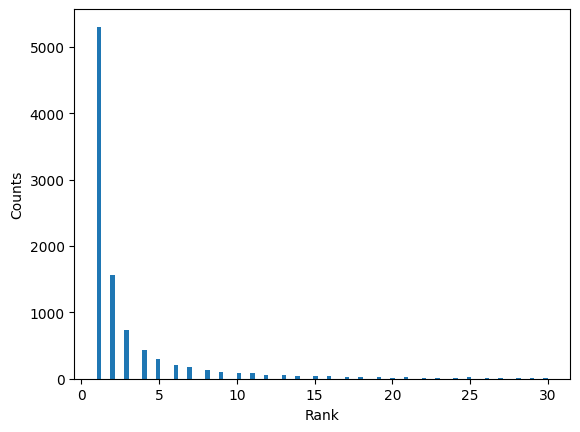

In [56]:
%matplotlib inline
arr = np.sort(rank_list)

plt.hist(arr[:int(arr.shape[0]*0.96)]+1, bins=100)
plt.xlabel("Rank")
plt.ylabel("Counts")
plt.show()